In [3]:
%matplotlib notebook
import sys, os
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
torch.cuda.is_available()

True

In [4]:
download = False

url = 'https://people.cs.pitt.edu/~mzhang/cs1699/cifar10.zip'

def download_and_unzip(url, output_path):
    import urllib, io, zipfile
    with urllib.request.urlopen(url) as f:
        zip_file = zipfile.ZipFile(io.BytesIO(f.read()))
        zip_file.extractall(path=output_path)

data_root = './cifar10'
train_set_dir = os.path.join(data_root, 'cifar10_train')
test_set_dir = os.path.join(data_root, 'cifar10_test')

if download:
    download_and_unzip(url, data_root)
    
os.listdir(data_root)

['cifar10_train', 'cifar10_test']

In [5]:
sorted(os.listdir(train_set_dir))

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Part A - Custom data loader

In [37]:
class CifarDataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, device):
        super().__init__()
        self.labels = []
        self.images = []
        self.label_map = sorted(os.listdir(root_dir))
        for label_idx, label in enumerate(self.label_map):
            label_dir = os.path.join(root_dir, label)
            for image_name in os.listdir(label_dir):
                image_file = os.path.join(label_dir, image_name)
                self.images.append(image_file)
                self.labels.append(label_idx)
        self.device = device

    @property
    def data_size(self):
        return 3 * 32 * 32

    @property
    def label_size(self):
        return 10

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_file = self.images[idx]
        image = torchvision.io.read_image(image_file)
        label = self.labels[idx]
        assert image.shape == (3, 32, 32) and label < 10

        # convert image and label to tensors
        image = torch.as_tensor(
            image.reshape(self.data_size) / 255 - 0.5,
            dtype=torch.float32,
            device=self.device
        )
        label = F.one_hot(
            torch.as_tensor(label), self.label_size
        ).to(self.device, dtype=torch.float32)
    
        return image, label

train_dataset = CifarDataset(train_set_dir, device='cpu')
train_dataset[0]

(tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [38]:
len(train_dataset)

50000

<IPython.core.display.Javascript object>


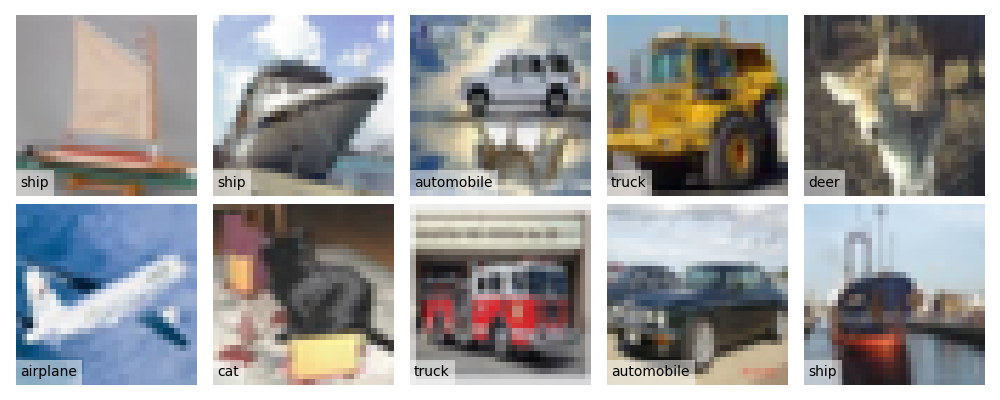

In [40]:
n_rows = 2
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

N = len(train_dataset)
inds = np.random.randint(N, size=(n_rows, n_cols))

for row in range(n_rows):
    for col in range(n_cols):
        ax = axes[row, col]

        image, label = train_dataset[inds[row, col]]
        image = image.reshape(3, 32, 32) + 0.5
        label = train_dataset.label_map[label.argmax()]

        ax.imshow(image.permute(1, 2, 0))
        ax.text(
            0.024, 0.048, f'{label}', transform=ax.transAxes,
            bbox=dict(alpha=0.5, fc='white', lw=0)
        )
        ax.axis('off')

fig.tight_layout()

# Part B - Training neural networks

In [61]:
class MultiLayerPerceptronModel(torch.nn.Module):

    def __init__(self, n_input, n_hidden, n_output, activ_fn, dropout):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_input, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fc3 = torch.nn.Linear(n_hidden, n_output)
        self.activ_fn = getattr(torch.nn.functional, activ_fn)

    def forward(self, x):
        x = self.activ_fn(self.fc1(x))
        x = self.activ_fn(self.fc2(x))
        return self.fc3(x)


<IPython.core.display.Javascript object>


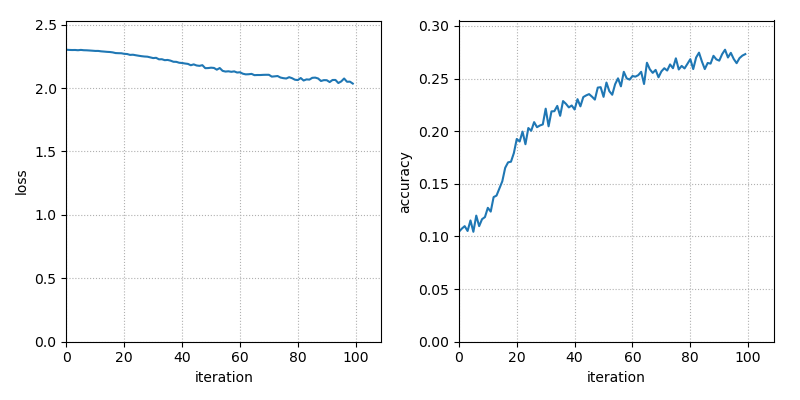

Epoch 1


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_20112/416341253.py:67: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[0].set_xlim(0, iteration * 1.1)
/tmp/ipykernel_20112/416341253.py:69: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax[1].set_xlim(0, iteration * 1.1)
100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


Epoch 2


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


Epoch 3


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Epoch 4


100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


Epoch 5


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Epoch 6


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Epoch 7


100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


Epoch 8


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Epoch 9


100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


Epoch 10


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


In [62]:
import tqdm

def training(
    root_dir,
    batch_size, n_hidden, activ_fn, dropout,
    optimizer, weight_decay, learning_rate, n_epochs,
    print_every=0,
    plot_every=0,
    **kwargs
):
    dataset = CifarDataset(root_dir, device='cuda')
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )
    N = len(dataset)

    model = MultiLayerPerceptronModel(
        dataset.data_size, n_hidden, dataset.label_size, activ_fn, dropout
    ).cuda()

    loss_fn = F.cross_entropy
    
    optim = getattr(torch.optim, optimizer)(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay, **kwargs
    )
    
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('iteration')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('iteration')
    for ax_ in ax:
        ax_.set_axisbelow(True)
        ax_.grid(linestyle=':')
    fig.tight_layout()
    
    iterations = []
    train_loss = []
    train_accy = []
    loss_line = ax[0].plot(iterations, train_loss)[0]
    accy_line = ax[1].plot(iterations, train_accy)[0]
    fig.canvas.draw()
    
    iteration = 0
    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}')
        for i, (images, labels) in tqdm.tqdm(enumerate(data_loader), total=N//batch_size):
            
            predictions = model.forward(images)
            loss = loss_fn(predictions, labels)
            accy = (predictions.detach().argmax(dim=1) == labels.argmax(dim=1)).float().mean()
            
            if print_every and (i + 1) % print_every == 0:
                print(f'[epoch {epoch+1}|batch {i+1}/{N//batch_size}] loss = {loss.item():.4f}, accuracy = {accy.item():.4f}')

            if plot_every and (i + 1) % plot_every == 0:
                iterations.append(iteration)
                train_loss.append(loss.item())
                train_accy.append(accy.item())

                loss_line.set_xdata(iterations)
                loss_line.set_ydata(train_loss)
                
                accy_line.set_xdata(iterations)
                accy_line.set_ydata(train_accy)
                
                ax[0].set_xlim(0, iteration * 1.1)
                ax[0].set_ylim(0, max(train_loss) * 1.1)
                ax[1].set_xlim(0, iteration * 1.1)
                ax[1].set_ylim(0, max(train_accy) * 1.1)
                fig.canvas.draw()
    
            loss.backward()
            optim.step()
            iteration += 1
            
    return model

model = training(
    train_set_dir,
    batch_size=5000,
    n_hidden=256,
    activ_fn='tanh',
    dropout=0.0,
    optimizer='SGD',
    learning_rate=1e-3,
    weight_decay=0,
    n_epochs=10,
    print_every=0,
    plot_every=1
)